### Utilizando boto3 para processamento de Linguagem Natural 
Neste tutorial iremos utilizar ferramentas de processamento de audio e texto e Linguagem Natural para analisar dados provenientes de vídeos do Youtube. Os arquivos serão baixados utilizando uma ferramenta de linha de comando chamada [Youtube-DL](https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme), e iremos utilizar os serviços de NLP oferecidos pela AWS, accessados pela biblioteca [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

In [6]:
# Bibliotecas que serão utilizadas ao longo do tutorial
from __future__ import print_function
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
%matplotlib inline

#### 1) Baixando arquivos de vídeo do Youtube
O primeiro passo em nosso tutorial é baixar os arquivos de áudio a partir de links de videos específicos selecionados. Para isso usaremos a ferramenta Youtube-DL que pode ser instalada através do ```pip```.

```sudo pip install youtube-dl```

Para baixar um vídeo qualquer: 

```youtube-dl <video_url>```

Como iremos trabalhar apenas com áudio, podemos usar o parâmetro ```-x``` e ```--audio-format "wav"``` para baixar somente a parte de áudio do vídeo do Youtube. 

```youtube-dl -x --audio-format "wav" <video_url>```

#### Lista de Vídeos de selecionados
Serão analisados 5 discursos gravados em vídeo e disponibilizados publicamente no Youtube. Segue a descrição de cada um deles:

A) ["We shall never surrender" de Winston Churchill](https://www.youtube.com/watch?v=s_LncVnecLA)
Esse discurso histórico foi proferido pelo Primeiro Ministro Britânico Winston Churchill no dia 4 junho de 1940. Nele, o estadista aborda a situação crítica no qual se encontrava os aliados frente a invasão nazista na França e da batalha de Dunkirk.

B) ["40o Aniversário de Invasão da Normandia", Ronald Reagan"](https://www.youtube.com/watch?v=1Leb7ynduCU)
No dia 6 de junho de 1984 Ronald Reagan, presidente americano em exercício na época, discursou na Normandia (França) em homenagem aos 40 anos do Dia-D. O discurso homenageou de forma marcante os soldados que morreram na batalha ao longo da costa norte francesa, e que de certa forma definiram o destino da Segunda Guerra, e consequentemente, da história moderna.

C) 



In [7]:
ls

 NLP_usando_AWS.ipynb
'WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.m4a'


In [28]:
dict_urls_youtube = {
    'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=1Leb7ynduCU',
    'luther_king': 'https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s',
    'bezos': 'https://www.youtube.com/watch?v=uvzkujQFlxQ',
    'gaiman': 'https://www.youtube.com/watch?v=plWexCID-kA'}

In [29]:
for url in list(dict_urls_youtube.values()):
    os.system(f'youtube-dl -x --audio-format "m4a" {url}')

In [31]:
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])

In [32]:
ls

'Amazon founder Jeff Bezos delivers speech at Princeton University - Engsub-uvzkujQFlxQ.m4a'
'I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.m4a'
"Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.m4a"
 NLP_usando_AWS.ipynb
"Normandy Speech - President Reagan's Address Commemorating 40th Anniversary of Normandy_D-Day  6_6_84-1Leb7ynduCU.m4a"
'WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.m4a'


In [12]:
df_audio

,youtube_urls
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ
gaiman,https://www.youtube.com/watch?v=plWexCID-kA


In [33]:
# Atribuindo nome do arquivo baixado a cada autor do discurso
for audio_file in os.listdir('.'):
    print(audio_file)
    if 'churchill' in audio_file.lower():
        df_audio.at['churchill','filename'] = audio_file
    elif 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
    elif 'king' in audio_file.lower():
        df_audio.at['luther_king', 'filename'] = audio_file
    elif 'bezos' in audio_file.lower():
        df_audio.at['bezos', 'filename'] = audio_file
    elif 'gaiman' in audio_file.lower():
        df_audio.at['gaiman', 'filename'] = audio_file

I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.m4a
.ipynb_checkpoints
Normandy Speech - President Reagan's Address Commemorating 40th Anniversary of Normandy_D-Day  6_6_84-1Leb7ynduCU.m4a
Amazon founder Jeff Bezos delivers speech at Princeton University - Engsub-uvzkujQFlxQ.m4a
.git
.gitignore
WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.m4a
Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.m4a
NLP_usando_AWS.ipynb


In [36]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


Configurando o AWS CLI pelo terminal
Para trabalhar com o boto3, você deve instalar o ```awscli```
```
$ pip install awscli --upgrade --user
```

E em seguida configurá-lo com as suas credenciais da AWS

```
aws configure
```

E definir os seguintes valores:

```
AWS Access Key ID [****************DNYA]: 
AWS Secret Access Key [****************oEG/]: 
Default region name [sa-east-1]: 
Default output format [json]:
```






In [54]:
boto3.setup_default_session(region_name='us-east-1')

In [55]:
#Subindo os arquivos para o S3
# Criar um cliente S3
s3 = boto3.client('s3')

# Buscar lista de buckets no S3
response = s3.list_buckets()

# Organizar a resposta em uma lista
buckets = [bucket['Name'] for bucket in response['Buckets']]

print("Bucket List: %s" % buckets)

Bucket List: ['elasticbeanstalk-us-east-1-089951219780', 'grupy-nlp-speeches', 'little-thomas-assets', 'medium-lambda-tutorial-bucket', 'regis-media', 'stackery-assetsbucket-p8b8xq12o1re', 'vision-pmp']


In [38]:
# Criando um novo bucket para subir os arquivos
try:
    s3.create_bucket(Bucket='grupy-nlp-speeches', CreateBucketConfiguration={
                              'LocationConstraint': 'sa-east-1'})
except:
    print('Bucket com o mesmo nome já criado.')

Bucket com o mesmo nome já criado.


In [17]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...


In [39]:
# Subindo os arquivos de audio para o bucket criado
for audio_file in df_audio.filename.values:
    print(audio_file)
    s3.upload_file(audio_file, 'grupy-nlp-speeches', audio_file)

WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.m4a
Normandy Speech - President Reagan's Address Commemorating 40th Anniversary of Normandy_D-Day  6_6_84-1Leb7ynduCU.m4a
I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.m4a
Amazon founder Jeff Bezos delivers speech at Princeton University - Engsub-uvzkujQFlxQ.m4a
Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.m4a


In [40]:
# Definir a url de cada arquivo no S3 no df_audio
s3_resource = boto3.resource('s3')
first_bucket = s3_resource.Bucket(name='grupy-nlp-speeches')
for obj in first_bucket.objects.all():
    url = '{}/{}/{}'.format(s3.meta.endpoint_url, 'grupy-nlp-speeches', obj.key.replace(' ', '+'))
    print(url)
    if 'churchill' in url.lower():
        df_audio.at['churchill','url'] = url
    elif 'reagan' in url.lower():
        df_audio.at['reagan', 'url'] = url
    elif 'king' in url.lower():
        df_audio.at['luther_king', 'url'] = url
    elif 'bezos' in url.lower():
        df_audio.at['bezos', 'url'] = url
    elif 'gaiman' in url.lower():
        df_audio.at['gaiman', 'url'] = url

https://s3.amazonaws.com/grupy-nlp-speeches/Amazon+founder+Jeff+Bezos+delivers+speech+at+Princeton+University+-+Engsub-uvzkujQFlxQ.m4a
https://s3.amazonaws.com/grupy-nlp-speeches/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.m4a
https://s3.amazonaws.com/grupy-nlp-speeches/Neil+Gaiman+2012+Commencement+Speech+'Make+Good+Art'-plWexCID-kA.m4a
https://s3.amazonaws.com/grupy-nlp-speeches/Normandy+Speech+-+President+Reagan's+Address+Commemorating+40th+Anniversary+of+Normandy_D-Day++6_6_84-1Leb7ynduCU.m4a
https://s3.amazonaws.com/grupy-nlp-speeches/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.m4a


In [48]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://s3.amazonaws.com/grupy-nlp-speeches/WE...
reagan,https://www.youtube.com/watch?v=1Leb7ynduCU,Normandy Speech - President Reagan's Address C...,https://s3.amazonaws.com/grupy-nlp-speeches/No...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://s3.amazonaws.com/grupy-nlp-speeches/I+...
bezos,https://www.youtube.com/watch?v=uvzkujQFlxQ,Amazon founder Jeff Bezos delivers speech at P...,https://s3.amazonaws.com/grupy-nlp-speeches/Am...
gaiman,https://www.youtube.com/watch?v=plWexCID-kA,Neil Gaiman 2012 Commencement Speech 'Make Goo...,https://s3.amazonaws.com/grupy-nlp-speeches/Ne...


In [42]:
s3 = boto3.client('s3')
url = '{}/{}/{}'.format(s3.meta.endpoint_url, 'grupy-nlp-speeches', "Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.wav")

In [43]:
url

"https://s3.amazonaws.com/grupy-nlp-speeches/Neil Gaiman 2012 Commencement Speech 'Make Good Art'-plWexCID-kA.wav"

In [44]:
bucket_location = boto3.client('s3').get_bucket_location(Bucket='grupy-nlp-speeches')
object_url = "https://s3-{0}.amazonaws.com/{1}/{2}".format(
    bucket_location['LocationConstraint'],
    'grupy-nlp-speeches',
    url)

In [58]:
for object in s3.objects.all():
    print(object)

AttributeError: 'S3' object has no attribute 'objects'

In [59]:
df_audio.at['luther_king', 'url']

'https://s3.amazonaws.com/grupy-nlp-speeches/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.m4a'

In [61]:
from __future__ import print_function
import time
import boto3
transcribe = boto3.client('transcribe')
job_name = "teste_boto3_transcribe_martinluther_august2019"
job_uri = df_audio.at['luther_king', 'url']
transcribe.start_transcription_job(
    TranscriptionJobName=job_name,
    Media={'MediaFileUri': job_uri},
    MediaFormat='mp4',
    LanguageCode='en-US'
)
while True:
    status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
    if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(5)
print(status)

BadRequestException: An error occurred (BadRequestException) when calling the StartTranscriptionJob operation: The S3 URI that you provided points to the incorrect region. Make sure that the bucket is in the us-east-1 region and try your request again.

In [62]:
# Transcrevendo de audio para texto usando Amazon Transcribe
transcribe = boto3.client('transcribe')
job_name = "teste_boto3_transcribe_martinluther"
job_uri = df_audio.at['luther_king', 'url']
transcribe.start_transcription_job(
    TranscriptionJobName=job_name,
    Media={'MediaFileUri': job_uri},
    MediaFormat='mp4',
    LanguageCode='en-US'
)
while True:
    status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
    if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(20)
print(status)

BadRequestException: An error occurred (BadRequestException) when calling the StartTranscriptionJob operation: The S3 URI that you provided points to the incorrect region. Make sure that the bucket is in the us-east-1 region and try your request again.

In [60]:
uri = status.get('TranscriptionJob').get('Transcript').get('TranscriptFileUri')

In [61]:
uri

'https://s3.sa-east-1.amazonaws.com/aws-transcribe-sa-east-1-prod/089951219780/teste_boto3_transcribe_martinluther/76a3795c-9470-406b-9ff8-b5ea3ca4d94f/asrOutput.json?X-Amz-Security-Token=FQoGZXIvYXdzELH%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDEgGU8CJhC1IYIWF7iK3Ax1EP%2F%2F%2BipBzV7jV4C6cQqD1NEftb7xVzyk3Ugeoj0DYm1VlhJiMHGNliPMYoiWQU1UL5OoYqiyve80%2FbhoAnflgAC2IXu9NYKbt%2BNegEbGjQaQqj5GyxNte2MgJI5bnvHKciirJwG3QLYYFvAwagIxDuraTy5Br31U5zTvRyC0ybNTJjC9pPsrAOMxr7OZk76jOlMSf8R4RFMxxoOhu4n62eHjNfpF1oDJljU5jw%2FNkuHexnoDn%2FdvKtnn3HD5Qcnml12YkN9MYiOXbA%2BdGmZWlcXzqYo0ehyS6jyI2GX3KDOo3GvbLs2%2Byw6zN53jgIqmVbN%2F8uWK%2FP%2FHHP80XeSSFGONCtLg1U7qDUe28PuvLwY%2BdaSet7U31qTgR5sOvnftiqdK%2BfygZR1hgVvO82eo5qHCg4CfMkBkVOlpFOE5SovaFU2yADdyuFxNZTrYqqX3HoqALIDzuEpdwaShYvgopVAdDzw055jfdNJkKMhu0oaj8SOS0wSrDP0d16CDxaLVyj4rmoa9jcYAhdT5hvWRqBaRSPpXZu%2FrA%2F48sY5ieyomW%2FNpY0qJBEFPVgIygdcOQFJgYS58o3p3E5AU%3D&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Date=20190319T170513Z&X-Amz-SignedHeaders=host&X-Amz-Expires=899&X-Amz-C

In [62]:
status.get('ResponseMetadata')

{'HTTPHeaders': {'connection': 'keep-alive',
  'content-length': '1665',
  'content-type': 'application/x-amz-json-1.1',
  'date': 'Tue, 19 Mar 2019 17:05:13 GMT',
  'x-amzn-requestid': '28fde52f-4a69-11e9-8582-bba1bac9e121'},
 'HTTPStatusCode': 200,
 'RequestId': '28fde52f-4a69-11e9-8582-bba1bac9e121',
 'RetryAttempts': 0}

In [63]:
status.get('ResponseMetadata')

{'HTTPHeaders': {'connection': 'keep-alive',
  'content-length': '1665',
  'content-type': 'application/x-amz-json-1.1',
  'date': 'Tue, 19 Mar 2019 17:05:13 GMT',
  'x-amzn-requestid': '28fde52f-4a69-11e9-8582-bba1bac9e121'},
 'HTTPStatusCode': 200,
 'RequestId': '28fde52f-4a69-11e9-8582-bba1bac9e121',
 'RetryAttempts': 0}

In [64]:
import json
import requests
response = requests.get(uri)
todos = json.loads(response.text)

In [65]:
todos

{'accountId': '089951219780',
 'jobName': 'teste_boto3_transcribe_martinluther',
 'results': {'items': [{'alternatives': [{'confidence': '0.9937',
      'content': 'I'}],
    'end_time': '0.34',
    'start_time': '0.19',
    'type': 'pronunciation'},
   {'alternatives': [{'confidence': '1.0000', 'content': 'have'}],
    'end_time': '0.63',
    'start_time': '0.35',
    'type': 'pronunciation'},
   {'alternatives': [{'confidence': '1.0000', 'content': 'the'}],
    'end_time': '0.81',
    'start_time': '0.64',
    'type': 'pronunciation'},
   {'alternatives': [{'confidence': '1.0000', 'content': 'pleasure'}],
    'end_time': '1.19',
    'start_time': '0.82',
    'type': 'pronunciation'},
   {'alternatives': [{'confidence': '1.0000', 'content': 'to'}],
    'end_time': '1.29',
    'start_time': '1.19',
    'type': 'pronunciation'},
   {'alternatives': [{'confidence': '1.0000', 'content': 'present'}],
    'end_time': '1.73',
    'start_time': '1.29',
    'type': 'pronunciation'},
   {'alter

In [47]:
todos.keys()

dict_keys(['jobName', 'accountId', 'results', 'status'])

In [66]:
text = todos.get('results').get('transcripts')[0].get('transcript')

In [6]:
text

NameError: name 'text' is not defined

In [7]:
len('ola tudo bem'.encode('utf-8'))

12

In [68]:
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
                
#text = "It is raining today in Seattle"

print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), 
                 sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "161",
            "content-type": "application/x-amz-json-1.1",
            "date": "Tue, 19 Mar 2019 17:06:41 GMT",
            "x-amzn-requestid": "5dda267f-4a69-11e9-a273-994e1d24e33c"
        },
        "HTTPStatusCode": 200,
        "RequestId": "5dda267f-4a69-11e9-a273-994e1d24e33c",
        "RetryAttempts": 0
    },
    "Sentiment": "NEUTRAL",
    "SentimentScore": {
        "Mixed": 0.03251306340098381,
        "Negative": 0.003233782947063446,
        "Neutral": 0.6469839215278625,
        "Positive": 0.3172691762447357
    }
}
End of DetectSentiment



In [25]:
## Visualização do resultado da análise de sentimento dos discursos

In [26]:
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LabelSet

num_vars = 9

theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
# rotate theta such that the first axis is at the top
theta += np.pi/2

def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.
    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

def radar_patch(r, theta):
    yt = (r + 0.01) * np.sin(theta) + 0.5
    xt = (r + 0.01) * np.cos(theta) + 0.5
    return xt, yt

verts = unit_poly_verts(theta)
x = [v[0] for v in verts] 
y = [v[1] for v in verts] 

p = figure(title="Radar")
text = ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3']
source = ColumnDataSource({'x':x+ [0.5],'y':y+ [1],'text':text})

p.line(x="x", y="y", source=source)

labels = LabelSet(x="x",y="y",text="text",source=source)

p.add_layout(labels)

# example factor:
f1 = np.array([0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00]) * 0.5
f2 = np.array([0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00]) * 0.5
f3 = np.array([0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00]) * 0.5
f4 = np.array([0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00]) * 0.5
f5 = np.array([0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]) * 0.5
#xt = np.array(x)
flist = [f1,f2,f3,f4,f5]
colors = ['blue','green','red', 'orange','purple']
for i in range(len(flist)):
    xt, yt = radar_patch(flist[i], theta)
    p.patch(x=xt, y=yt, fill_alpha=0.15, fill_color=colors[i])
show(p)

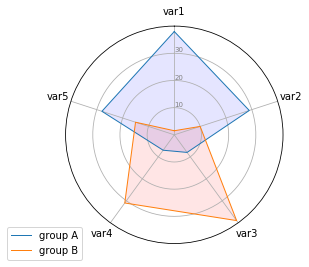

In [27]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


Bibliografia e Links
* Tutorial de reconhecimento de audio em Python https://realpython.com/python-speech-recognition/
* Tutorial de como baixar videos do Youtube usando linha de comando no Linux https://itsfoss.com/download-youtube-linux/
* Projeto Youtube-DL https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme
* Discurso “We Shall Fight on the Beaches” de Winston Churchill https://www.artofmanliness.com/we-shall-fight-on-the-beaches-by-winston-churchill/
* Discurso “40th Anniversary of D-Day” de Ronald Regan https://www.artofmanliness.com/40th-anniversary-of-d-day-by-ronald-regan/ https://www.youtube.com/watch?v=eEIqdcHbc8I
* Discurso "I Have a Dream" de Martin Luther King https://kinginstitute.stanford.edu/king-papers/documents/i-have-dream-address-delivered-march-washington-jobs-and-freedom
* Discurso “What Matters More Than Your Talents” de Jeff Bezos https://jamesclear.com/great-speeches/what-matters-more-than-your-talents-by-jeff-bezos
* Discurso “Make Good Art” de Neil Gaiman https://jamesclear.com/great-speeches/make-good-art-by-neil-gaiman
* Tutorial de configuração de conta AWS e boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#using-boto-3
* Tutorial de como lidar com Json no Python https://realpython.com/python-json/
* Curso de 'Natural Language Processing Fundamentals in Python' do DataCamp https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python